In [1]:
# Initialization cell
%pylab notebook
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


# Simple linear regression 

The first type of model, which we will spend a lot of time on, is the *simple linear regresssion model*. One simple way to think of it
is via scatter plots. Below are [heights](http://www.stat.cmu.edu/~roeder/stat707/=data/=data/data/Rlibraries/alr3/html/heights.html) of mothers and daughters collected 
by Karl Pearson in the late 19th century. 

In [2]:
%%R -o M,D
library(alr3)
data(heights)
M = heights$Mheight
D = heights$Dheight

/Users/jonathantaylor/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: car

  res = super(Function, self).__call__(*new_args, **new_kwargs)


<IPython.core.display.Javascript object>


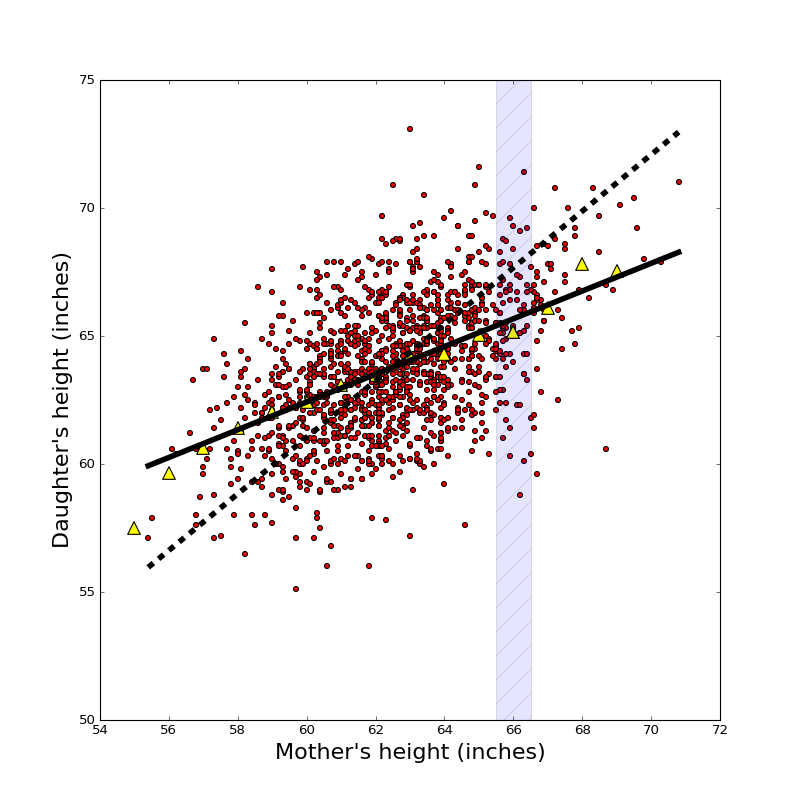

In [3]:
heights_fig = plt.figure(figsize=(10,10))
axes = heights_fig.gca()
axes.scatter(M, D, c='red')
axes.set_xlabel("Mother's height (inches)", size=20)
axes.set_ylabel("Daughter's height (inches)", size=20)


A simple linear regression model fits a line through the above scatter plot in a particular way. Specifically, it tries to estimate
the height of a new daughter in this population, say $D_{new}$, whose mother had height $H_{new}$. It does this by considering
each slice of the data. Here is a slice of the data near $M=66$, the slice is taken over a window of size 1 inch.

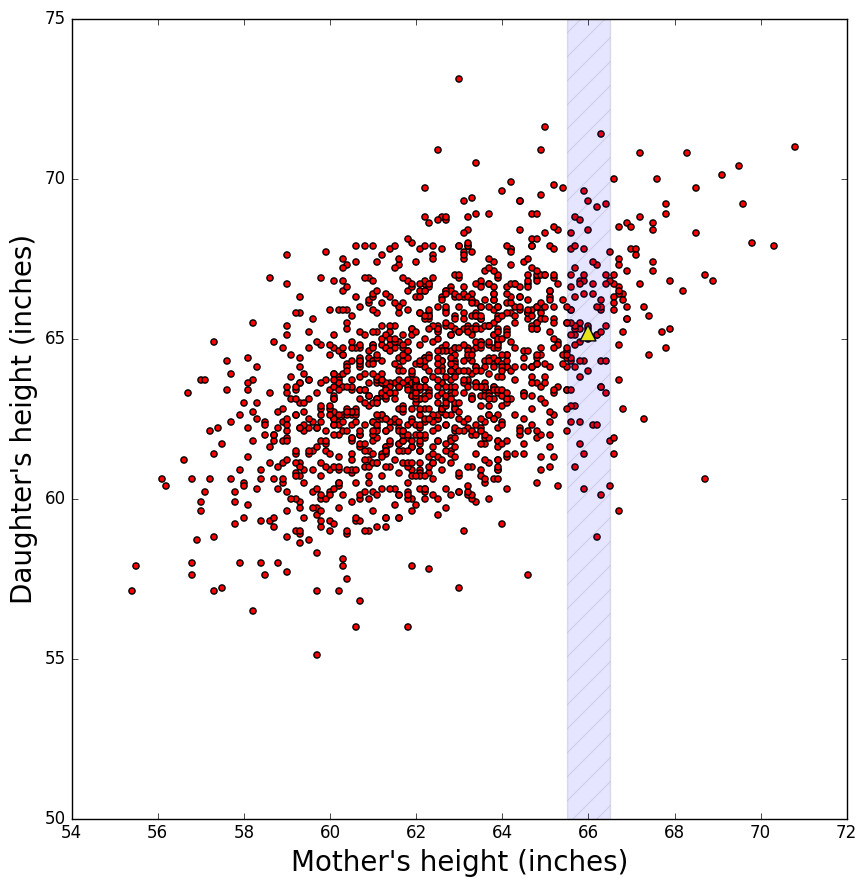

In [4]:
X = 66
xf, yf = mlab.poly_between([X-.5,X+.5], [50,50], [75, 75])
selected_points = (M <= X+.5) * (M >= X-.5)
mean_within_slice = D[selected_points].mean()
scatterplot_slice = axes.fill(xf, yf, facecolor='blue', alpha=0.1, hatch='/')[0]
axes.set_ylim([50,75])
axes.scatter([X],[mean_within_slice], s=130, c='yellow', marker='^')
heights_fig


In [5]:
print mean_within_slice

65.1733333333


We see that, in our sample, the average height of daughters whose height fell within our slice is about 65.2 inches. Of course this
height varies by slice. For instance, at 60 inches:

In [6]:
X = 60
selected_points = (M <= X+.5) * (M >= X-.5)
mean_within_slice = D[selected_points].mean()
print mean_within_slice

62.4282894737


The regression model puts a line through this scatter plot in an *optimal* fashion.



In [7]:
%%R -o slope,intercept
parameters = lm(D ~ M)$coef
print(parameters)
intercept = parameters[1]
slope = parameters[2]

(Intercept)           M 
  29.917437    0.541747 


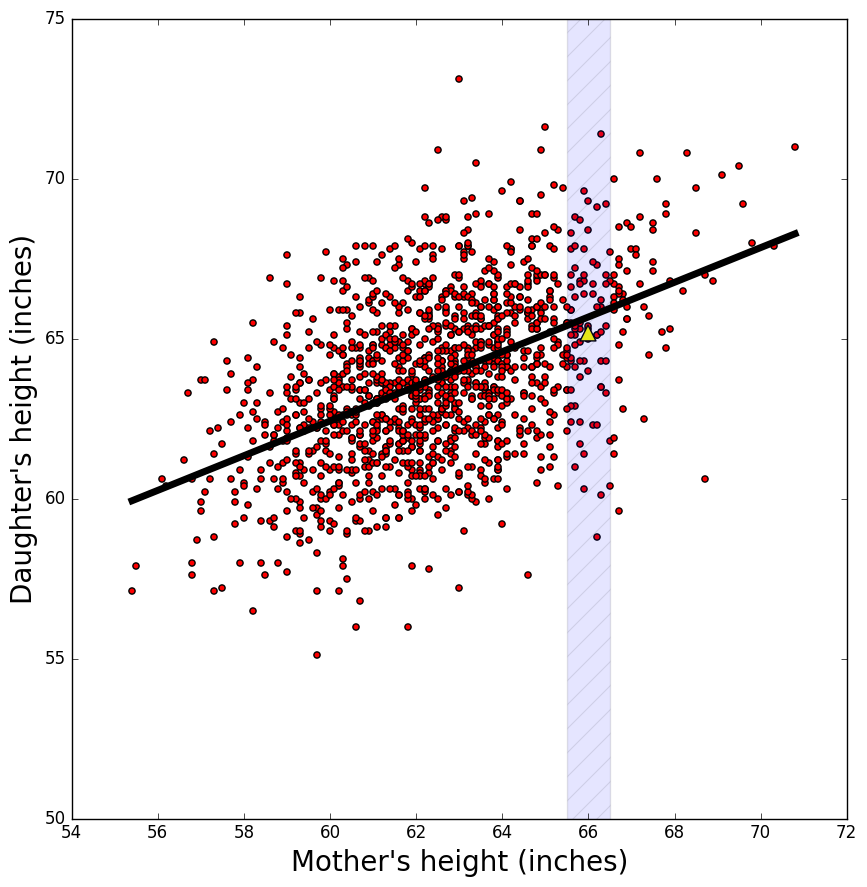

In [8]:
axes.plot([M.min(), M.max()], [intercept + slope * M.min(), intercept + slope * M.max()], 'k',
          linewidth=5)
heights_fig


### SD line

The SD line passes through the point of averages and has slope $SD(D)/SD(M)$.

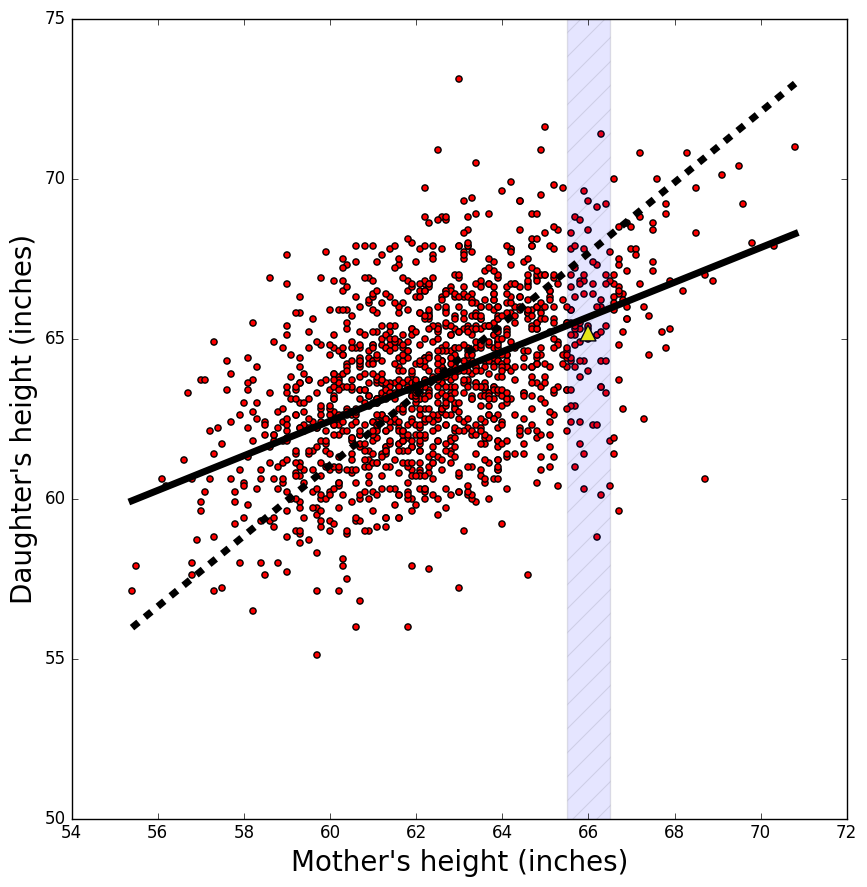

In [9]:
SDslope = np.std(D) / np.std(M)
SDintercept = np.mean(D) - SDslope * np.mean(M)
axes.plot([M.min(), M.max()], [SDintercept + SDslope * M.min(),
                               SDintercept + SDslope * M.max()], 'k--',
          linewidth=5)
heights_fig

## Graph of averages

Let's compare our two lines to the graph of averages, depicted in yellow triangles below.

We see that the regression line is quite close to the graph of averages, whereas the SD line is not.

The fact that it is the regresssion line that passes closest to the graph of averages instead of the SD line
is related to [regression to the mean](https://en.wikipedia.org/wiki/Regression_toward_the_mean). 

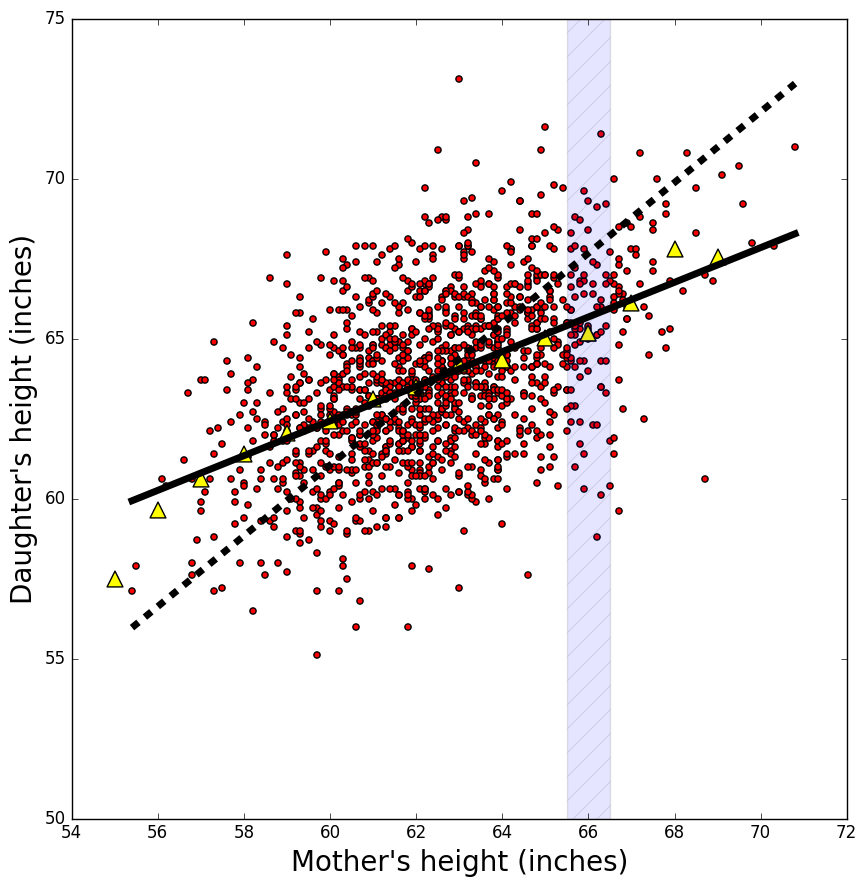

In [10]:
def slice_average(X, delta=1):
    selected_points = (M <= X+.5*delta) * (M >= X-.5*delta)
    mean_within_slice = D[selected_points].mean()
    return mean_within_slice

axes.scatter(np.arange(55,70), [slice_average(x) for x in np.arange(55, 70)], s=130, c='yellow', marker='^')
heights_fig

## Mathematical description of regression line

A line $L$ is determined by its slope and intercept:
$$
L = \left\{(y,x): y = \beta_0 + \beta_1 x \right\}.
$$

For each line, we can compute the *error sum of squares* on a dataset $D = \{(X_i,Y_i): 1 \leq i \leq n\}$:
$$
SSE(L) = SSE(\beta_0, \beta_1; X, Y) = \sum_{i=1}^n (Y_i - (\beta_0 + \beta_1 X_i))^2.
$$

### Theorem (Gauss)

Among all lines, the regression line has the smallest $SSE$.
Or,
$$
\DeclareMathOperator{\argmin}{argmin}
\hat{\beta}(X,Y) = (\hat{\beta}_0(X,Y), \hat{\beta}_1(X,Y)) = \argmin_{(\beta_0,\beta_1)} SSE(\beta_0, \beta_1; X, Y).
$$

Obviously, $\hat{\beta}$ is a function of the dataset $D$.

### Simple linear regression model

* Let $Y_i$ be the height of the $i$-th daughter in the sample, $X_i$ be the height of the $i$-th mother.

* Model:
   $$Y_i = \underbrace{\beta_0 + \beta_1 X_i}_{\text{regression equation}} + \underbrace{\varepsilon_i}_{\text{error}}.$$
   
* Putting a distribution on $\varepsilon_i$'s and $X_i$'s specifies a *joint distribution* for the $Y$'s and $X$'s. 

* Alternatively, if we condition on $X$ we only need specify a distribution for $\varepsilon_i$'s to specify
a distribution for $Y_i$'s given $X$.

* Most common modelling assumption: the Gaussian model
$$
\epsilon_i | X \overset{IID}{\sim} N(0, \sigma^2).
$$


### Fitting the model

* We will begin by using *least squares* regression. This measures
   the *goodness of fit* of a line by the sum of squared errors, $SSE$.
   
* Least squares regression chooses the line that minimizes
   $$
   SSE(\beta_0, \beta_1) = SSE(\beta_0, \beta_1; X, Y) = \sum_{i=1}^n (Y_i - \beta_0 - \beta_1 \cdot X_i)^2.$$

* In principle, we might measure goodness of fit differently: 
   $$
   SAD(\beta_0, \beta_1) = \sum_{i=1}^n |Y_i - \beta_0 - \beta_1 \cdot X_i|.$$
   
* For some *loss function* $L$ we might try to minimize
    $$
    L(\beta_0,\beta_1) = \sum_{i=1}^n L(Y_i-\beta_0-\beta_1X_i) 
    $$


### Choice of loss function

The choice of the function we use to measure goodness of fit, or the *loss* function, has an outcome on what
sort of estimates we get out of our procedure. For instance, if, instead of fitting a line to a scatterplot, we were
estimating a *center* of a distribution, which we denote by $\mu$, then we might consider minimizing several loss functions.

* If we choose the sum of squared errors:
$$
SSE(\mu) = \sum_{i=1}^n (Y_i - \mu)^2.
$$
Then, we know that the minimizer of $SSE(\mu)$ is the sample mean.

* On the other hand, if we choose the sum of the absolute errors
 $$
   SAD(\mu) = \sum_{i=1}^n |Y_i - \mu|.$$
   Then, the resulting minimizer is the sample median.
   
* Both of these minimization problems also have *population* versions as well. For instance, the population mean
minimizes, as a function of $\mu$
$$
\mathbb{E}((Y-\mu)^2)
$$
while the population median minimizes
$$
\mathbb{E}(|Y-\mu|).
$$

### Visualizing the loss function

Let's take the Hooke's law data from Chapter 2 and visualize its loss function.


<IPython.core.display.Javascript object>


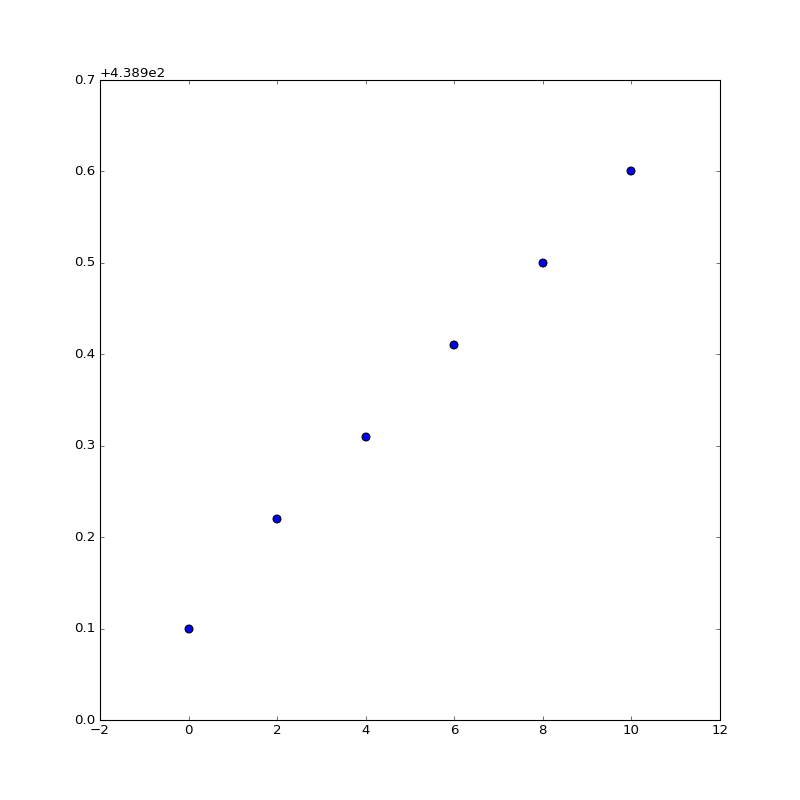

In [11]:
X = np.array([0., 2., 4., 6., 8., 10.])
Y = np.array([439.00, 439.12, 439.21, 439.31, 439.40, 439.50])
f = plt.figure(figsize=(10,10)); a = f.gca()
a.scatter(X, Y, s=50)

We've briefly seen how to fit a model in `R`. Let's take a look at how we might
fit it in `python` directly.

In [12]:
import statsmodels.api as sm
np.random.seed(0)
design = sm.add_constant(X)
intercept, slope = sm.OLS(Y,design).fit().params
intercept, slope, np.sum((Y - intercept - slope*X)**2)

(439.01095238095269, 0.049142857142850715, 0.00028190476190496374)

Now let's plot the *loss* as a function of the parameters. 

<IPython.core.display.Javascript object>


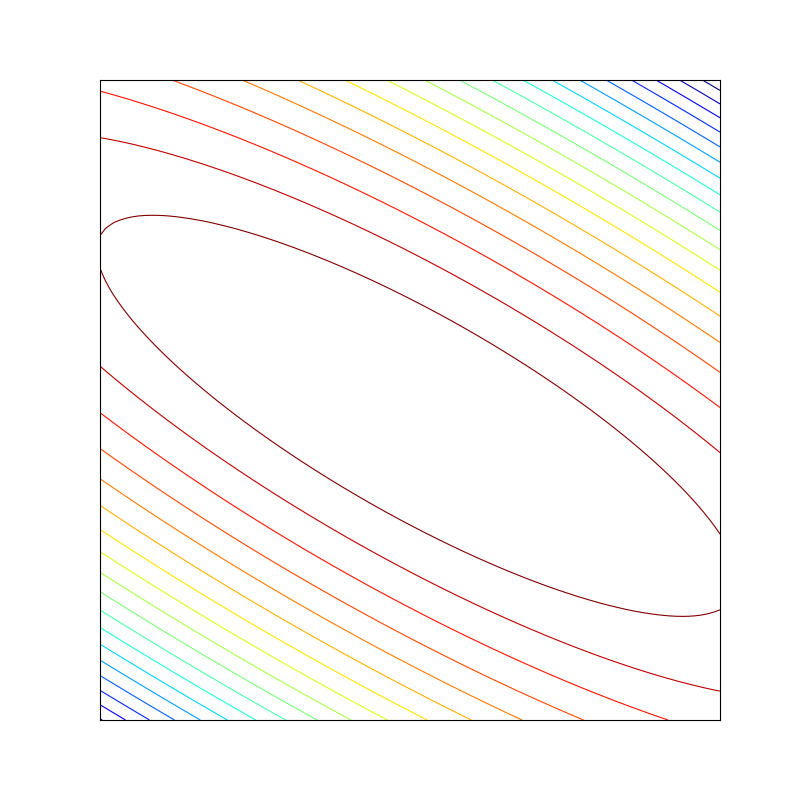

[]

In [13]:
squared_error_loss = plt.figure(figsize=(10,10))
grid = np.mgrid[420:460:100j,(-2):2:100j]
squared_errors = (Y[:,None,None] - grid[0] - X[:,None,None] * grid[1])**2
axes = squared_error_loss.gca()
axes.contour(-squared_errors.sum(0), 20, origin='lower', interpolation='nearest')
axes.set_xticks([])
axes.set_yticks([])

Let's contrast this with the sum of absolute errors. The contours of absolute
loss are piecewise linear, unlike the smooth contours of the squared error.

<IPython.core.display.Javascript object>


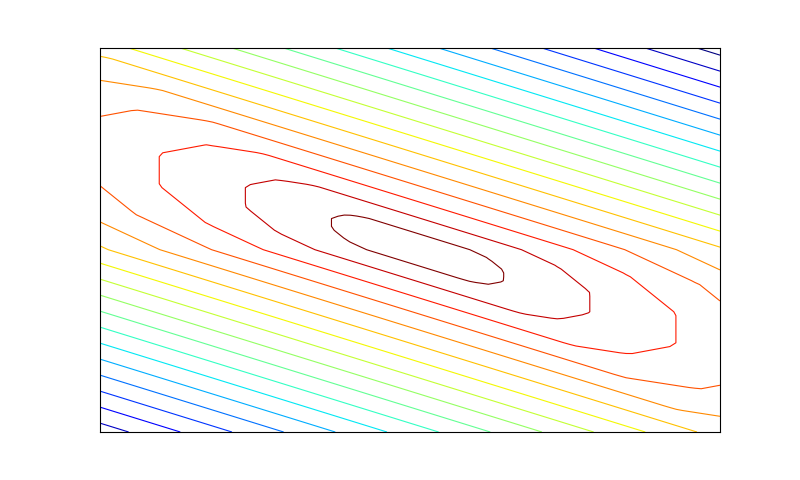

[]

In [14]:
absolute_error_loss = plt.figure(figsize=(10,6))
absolute_errors = np.fabs(Y[:,None,None] - grid[0] - X[:,None,None] * grid[1])
axes = absolute_error_loss.gca()
axes.contour(-absolute_errors.sum(0), 20, origin='lower', interpolation='nearest')
axes.set_xticks([])
axes.set_yticks([])


### From SSE to geometry

Earlier, we assigned each line, determined by  $(\beta_0, \beta_1)$ a number, its $SSE$. 

Given the vectors $X$ and $1$, each points in $\mathbb{R}^n$, we can form a new point by considering
the linear combination
$$
\beta_0 \cdot 1 + \beta_1 \cdot X.
$$

We see that
$$
SSE(\beta_0, \beta_1;X, Y) = \|Y - (\beta_0 \cdot 1+ \beta_1 \cdot X)\|^2
$$
is the distance between the above point and the vector $Y$.

Choosing the line with smallest $SSE$ is therefore the same as choosing the linear combination 
of $1$ and $X$ that is closest to $Y$. It is the *projection* of $Y$ onto the plane spanned by $\{1, X\}$.

### Fitted values and residuals

Having found $\hat{\beta}(X,Y)$ we can form the vector of *fitted values*
$$
\hat{Y} = \hat{\beta}_0 \cdot 1 + \hat{\beta}_1 \cdot X
$$
as well as the vector of residuals
$$
e = Y - \hat{Y}.
$$

Note that
$$
Y = \hat{Y} + e
$$
Or, for each data point
$$
Y_i = \hat{Y}_i + e_i = \hat{\beta}_0 + \hat{\beta}_1 X_i + e_i.
$$

Compare this to the regression model
$$
Y_i = \beta_0 + \beta_1 X_i + \varepsilon_i.
$$
If we like, we might take the Gauss model $\varepsilon_i | X \overset{IID}{\sim} N(0,\sigma^2)$.

### Complexities

What is different in the last two equations?

- The quantities $\beta_0, \beta_1$ are parameters and are not random. They are unknown.

- The quantities $\hat{\beta}_0, \hat{\beta}_1$ are functions of the data. If the data is random, they are therefore
random variables.

- The data set is observed. We think of these as realizations from our idealized Gauss model.

- The residuals $e_i$ are observed: they are functions of the data set. The errors $\varepsilon_i$ are unobservable. If we could observe them, then we could find $\beta_0, \beta_1$ exactly. (How?)

- Because the Gauss model specifies the distribution of $Y_i|X$ (and conditions on $X$) it also can tell
us the joint distribution of $(\hat{\beta}_0, \hat{\beta}_1)$.

### Geometry of least squares

The following picture will be with us, in various guises, throughout much of the course. It depicts
the geometric picture involved in least squares regression.

<img src="http://web.stanford.edu/class/stats203/figs/axes_simple.svg">

It requires some imagination but the picture should be thought as representing vectors in $n$-dimensional space, l where $n$ is the number of points in the scatterplot. In our height data, $n=1375$. The bottom two axes should be thought of as 2-dimensional, while the axis marked "$\perp$" should be thought of as $(n-2)$ dimensional, or, 1373 in this case.



## Important lengths

The (squared) lengths of the above vectors are important quantities in what follows.

There are three to note:
$$
\begin{aligned}
   SSE &= \|Y - \hat{Y}\|^2 = \sum_{i=1}^n (Y_i - \widehat{\beta}_0 - \widehat{\beta}_1 X_i)^2 \\
   SSR &= \|\overline{Y} \cdot 1 - \hat{Y}\|^2 = \sum_{i=1}^n (\overline{Y} - \widehat{\beta}_0 - \widehat{\beta}_1 X_i)^2 \\
   SST &= \|Y - \overline{Y} \cdot 1\|^2 = \sum_{i=1}^n(Y_i - \overline{Y})^2 = SSE + SSR \\
   \end{aligned}
$$

(When we introduced $SSE$ it was a function of $(\beta_0, \beta_1)$. Above, there are no arguments to $SSE$. Why?)

An important summary of the fit is the ratio
$$
R^2 = \frac{SSR}{SST} = 1 - \frac{SSE}{SST}
$$
which measures *how much variability in $Y$* is explained by $X$.

## Example: wages vs. experience


In this example, we'll look at the output of *lm* for the wage
data and verify that some of the equations we present for the 
least squares solutions agree with the output.
The data was compiled from a study in econometrics [Learning about Heterogeneity in Returns to Schooling]( http://www.econ.queensu.ca/jae/2004-v19.7/koop-tobias/readme.kt.txt).


In [15]:
%%R
url = 'http://stats191.stanford.edu/data/wage.csv'
wages = read.table(url, sep=',', header=T)
print(head(wages))
mean(logwage)

  education  logwage
1  16.75000 2.845000
2  15.00000 2.446667
3  10.00000 1.560000
4  12.66667 2.099167
5  15.00000 2.490000
6  15.00000 2.330833
Error in mean(logwage) : object 'logwage' not found


/Users/jonathantaylor/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in mean(logwage) : object 'logwage' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In order to access the variables in `wages` we `attach` it so that the variables
are in the toplevel namespace.

In [16]:
%%R
attach(wages)
mean(logwage)

[1] 2.240279


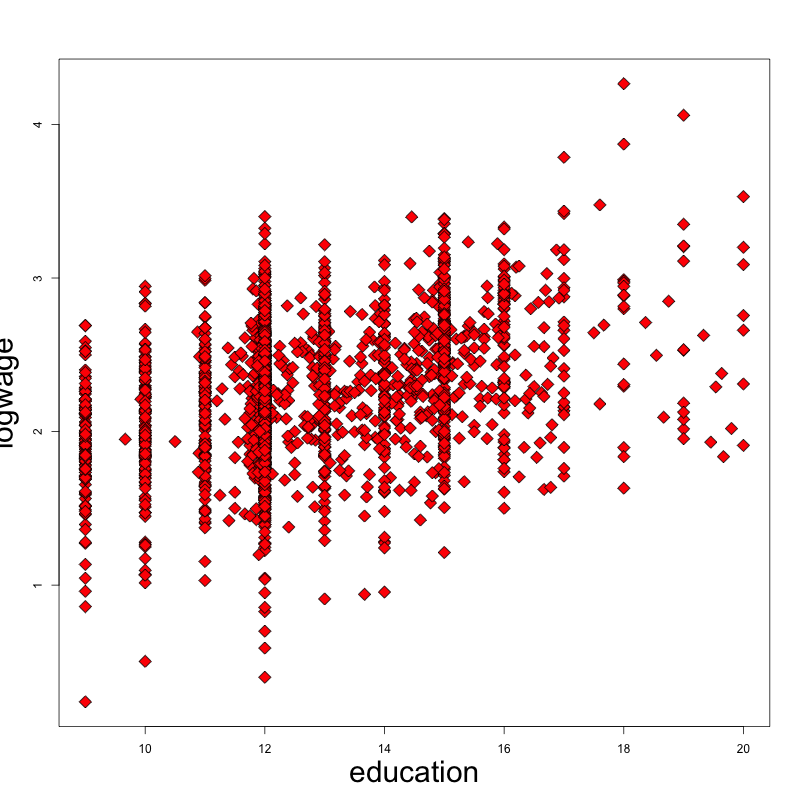

In [17]:
%%R -h 800 -w 800
plot(education, logwage, pch=23, bg='red', cex=1.8, cex.lab=2.5)

Let's fit the linear regression model and add it to the plot.

In [18]:
%%R
wages.lm = lm(logwage ~ education)
print(wages.lm)


Call:
lm(formula = logwage ~ education)

Coefficients:
(Intercept)    education  
     1.2392       0.0786  



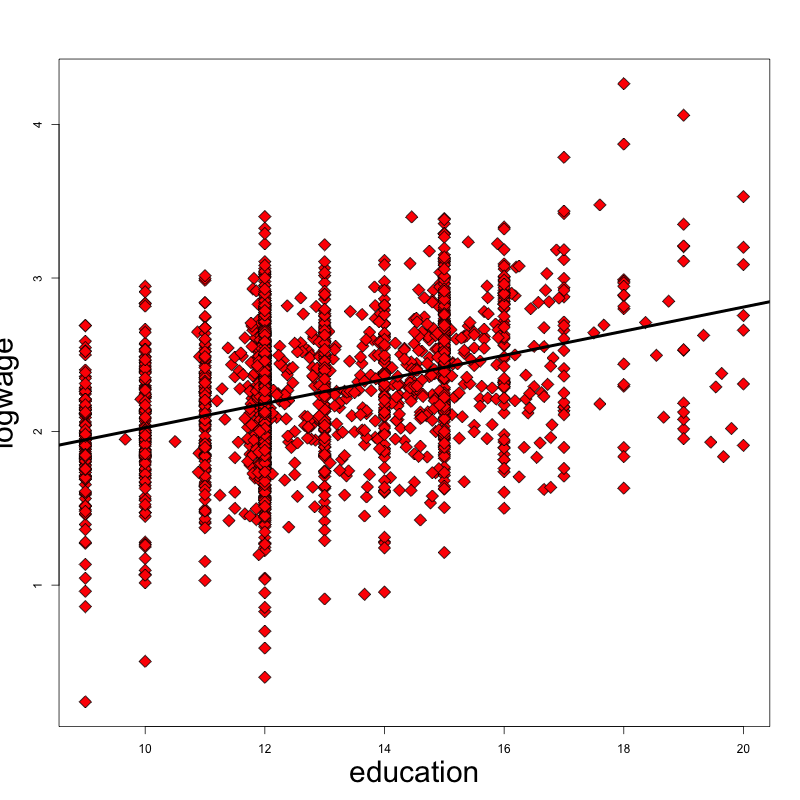

In [19]:
%%R -h 800 -w 800
plot(education, logwage, pch=23, bg='red', cex=1.8, cex.lab=2.5)
abline(wages.lm, lwd=4, col='black')

## The Gauss model for simple linear regression

### Fixed X

Recall our Gauss model, where we consider $X$ fixed and model
$$
Y_i | X \sim N(\beta_0 + \beta_1 \cdot X_i, \sigma^2)
$$
independently for $1 \leq i \leq n$.

This seems like a good model for the Hooke's law experiment

### Random X

In our mother-daughter example, it may not make sense to think of $X$ as fixed. After all,
Pearson did not fix the heights of the mothers in the study before collecting the data.

The analog of the Gaussian model in the random $X$ setting is to assume that the pairs $(X_i, Y_i)$
are jointly Gaussian (more on this soon) and independent.

If this Gaussian model is true, scatterplots tend to look like nice data clouds. The heights of mothers
and daughters above seem to fit this model.

What about `logwage` vs. `education`?

What does the regression model mean in this case?



### Least squares estimators

There are explicit formulae for the least squares estimators, i.e. the minimizers of the error sum of squares.

For the slope, $\hat{\beta}_1$, we will show that
$$
   \widehat{\beta}_1 = \frac{\sum_{i=1}^n(X_i - \overline{X})(Y_i - \overline{Y}
)}{\sum_{i=1}^n (X_i-\overline{X})^2} = 
\frac{\widehat{Cov}(X,Y)}{\widehat{Var}(X)}.$$

Knowing the slope estimate, the intercept estimate can be found easily:
$$ 
\widehat{\beta}_0 = \overline{Y} - \widehat{\beta}_1 \cdot \overline{X}.$$



#### Wages example

In [20]:
%%R
beta.1.hat = cov(education, logwage) / var(education)
beta.0.hat = mean(logwage) - beta.1.hat * mean(education)
print(c(beta.0.hat, beta.1.hat))
print(coef(wages.lm))

[1] 1.23919433 0.07859951
(Intercept)   education 
 1.23919433  0.07859951 


### Estimate of $\sigma^2$

There is one final quantity needed to estimate all of our parameters in our Gauss model for the scatterplot. This is $\sigma^2$,
the variance of the random variation within each slice (the regression model assumes this variance is constant within each slice...).

The estimate most commonly used is
$$
\hat{\sigma}^2 = \frac{1}{n-2} \sum_{i=1}^n (Y_i - \hat{\beta}_0 - \hat{\beta}_1 X_i)^2 = \frac{SSE}{n-2} = MSE
$$

(Above, note the practice of replacing the quantity $SSE(\hat{\beta}_0,\hat{\beta}_1)$, i.e. the minimum of this function, with just $SSE$.)

The term *MSE* above refers to mean squared error: a sum of squares divided by what we call its *degrees of freedom*. The degrees of freedom
of *SSE*, the *error sum of squares* is therefore $n-2$. Remember this $n-2$ corresponded to $\perp$ in the picture above...

If our Gauss model is correct, then we will see that
$$
\frac{\hat{\sigma}^2}{\sigma^2} \sim \frac{\chi^2_{n-2}}{n-2}
$$
where the right hand side denotes a *chi-squared* distribution with $n-2$ degrees of freedom.

#### Wages example

In [21]:
%%R
sigma.hat = sqrt(sum(resid(wages.lm)^2) / wages.lm$df.resid)
sigma.hat

[1] 0.4037828


The summary from *R* also contains this estimate of $\sigma$:

In [22]:
%%R
summary(wages.lm)


Call:
lm(formula = logwage ~ education)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.78239 -0.25265  0.01636  0.27965  1.61101 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.239194   0.054974   22.54   <2e-16 ***
education   0.078600   0.004262   18.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4038 on 2176 degrees of freedom
Multiple R-squared:  0.1351,	Adjusted R-squared:  0.1347 
F-statistic:   340 on 1 and 2176 DF,  p-value: < 2.2e-16



# Some theory simple linear regression model

- What can we say about our least squares estimators?

- In the Gauss model, we can say a lot. (We will come to this later.)

- What if the Gauss model is not correct?


## Random X model

- In principle, our least squares estimators are just functions of a scatter plot, like our 
`logwage` vs. `education` example.

- Perhaps the simplest model is to assume that the points $(X_i, Y_i)_{1 \leq i \leq n}$ are independently
drawn from some distribution $F$ on $\mathbb{R}^2$. 

- In this case, $\hat{\beta}=\hat{\beta}^n$ is a function of a sample of $n$ independent draws from $F$. What
do we expect will happen as $n$ grows?

- We saw that
$$
\hat{\beta}^n_1 = \frac{\widehat{Cov}^n(X,Y)}{\widehat{Var}^n(X)},
$$
where $n$ denotes the size of our sample.

- For $n$ large, by the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) (you will 
certainly see this in some form in STATS 200) we expect
$$
\begin{aligned}
\widehat{Cov}^n(X,Y) &\approx Cov_F(X,Y) \\
\widehat{Var}^n(X) &\approx Var_F(X). \\
\end{aligned}
$$

(What random variables are we applying the Law of Large Numbers to?)

- Therefore, we expect, for large $n$
$$
\hat{\beta}^n_1 \approx \frac{Cov_F(X,Y)}{Var_F(X)} = \beta_1(F).
$$
(The notation $\beta_1(F)$ indicates that if you knew the distribution $F$, you could compute the number to the right of the $\approx$ symbol.)

### Limiting distribution

- In order to construct hypothesis tests about $\beta_1(F)$ we need to know how close
$\hat{\beta}^n_1$ is to $\beta_1(F)$. 

- These type of results fall under the heading of [Central Limit Theorems](https://en.wikipedia.org/wiki/Central_limit_theorem) (also something you will see in STATS200).

- Define $\epsilon(X,Y)$ by
$$
Y = \beta_0(F) + \beta_1(F)  \cdot X + \epsilon(X, Y).
$$

- We will show that
$$
\begin{aligned}
E_F(\epsilon(X,Y)) &= 0 \\
E_F(X \epsilon(X,Y)) &= 0 \\
\hat{\beta}^n_1 &= \beta_1(F) + \frac{\frac{1}{n} \sum_{i=1}^n (X_i - \overline{X}) \epsilon_i}{\frac{1}{n} \sum_{i=1}^n (X_i - \overline{X})^2} \\
&= \beta_1(F) + \frac{\overline{X\cdot \epsilon} - \overline{X} \cdot \overline{\epsilon}}{\frac{1}{n} \sum_{i=1}^n (X_i - \overline{X})^2} \\
&= \beta_1(F) + \frac{\overline{X\cdot \epsilon} - E_F(X) \cdot \overline{\epsilon}}{Var_F(X)} + R_n \\
\end{aligned}
$$
(where the remainder $R_n$ can be ignored in a precise enough sense).

- The quantity
$$
\frac{\overline{X\cdot \epsilon} - E_F(X) \cdot \overline{\epsilon}}{Var_F(X)}
$$
is the sample mean of a sequence of centered random variables. The CLT applies to this random variable, it has
size roughly $n^{-1/2}$. The remainder has size roughly $n^{-1}$ so is much smaller as $n$ grows.

- From this, we will deduce that $\hat{\beta}_1^n$ is asymptotically Gaussian *even if our Gauss model does not hold.*

- We see that
$$
Var_F(n^{1/2} (\hat{\beta}^n - \beta_1(F))) = \frac{Var_F(X \cdot \epsilon - E_F(X) \cdot \epsilon)}{Var_F(X)^2}
$$

### Theory for the Gauss model, random X

- In the Gauss model, where $(X,Y)$ are jointly Normal (i.e. $F$ is a bivariate Normal distribution)
we will see that
$$
\begin{aligned}
\epsilon(X,Y) &= Y - E_F[Y|X] \sim N(0, Var_F(Y|X))
\end{aligned}$$
and is independent of $X$. (In this model, $Var_F(Y|X)$ does not depend on $X$).

- Further,
$$
\frac{Var_F(X \cdot \epsilon - E_F(X) \cdot \epsilon)}{Var_F(X)^2} = \frac{Var_F(Y|X)}{Var_F(X)}.
$$


### Theory for the Gauss model, fixed X

* The Gauss model has a very well-developed theory that does not even need
asymptotic justification. We will now take a look at this theory.


* Let $L$ be the subspace of $\mathbb{R}^n$ spanned $\pmb{1}=(1, \dots, 1)$ and ${X}=(X_1, \dots, X_n)$.

* Then,
   $${Y} = P_L{Y} + ({Y} - P_L{Y}) = \widehat{{Y}} + (Y - \widehat{{Y}}) = \widehat{{Y}} + e$$

* In our model $\mu=\beta_0 \pmb{1} + \beta_1 {X} \in L$ so that
   $$
   \widehat{{Y}} = \mu + P_L{\varepsilon}, \qquad {e} = P_{L^{\perp}}{{Y}} = P_{L^{\perp}}{\varepsilon}$$
 
* Our assumption that $\varepsilon_i$'s are independent $N(0,\sigma^2)$ tells us that: ${e}$ and $\widehat{{Y}}$ are independent; $\widehat{\sigma}^2 = \|{e}\|^2 / (n-2) \sim \sigma^2 \cdot \chi^2_{n-2} / (n-2)$.

- (Why do we know this is true? Follows from some facts about Normal distribution we will soon see.)



* In turn, this implies
$$
   \widehat{\beta}_1 \sim N\left(\beta_1, \frac{\sigma^2}{\sum_{i=1}^n(X_i-\overline{X})^2}\right).$$

* Therefore, $$\frac{\widehat{\beta}_1 - \beta_1}{\sigma \sqrt{\frac{1}{\sum_{i=1}^n(X_i-\overline{X})^2}}} \sim N(\
0,1).$$

* The other quantity we need is the *standard error* or SE of $\hat{\beta}_1$. This is
obtained from estimating the variance of $\widehat{\beta}_1$, which, in this case means simply
plugging in our estimate of $\sigma$, yielding
$$
   SE(\widehat{\beta}_1) = \widehat{\sigma} \sqrt{\frac{1}{\sum_{i=1}^n(X_i-\overline{X})^2}} \qquad 
   \text{independent of $\widehat{\beta}_1$}$$


## Inference for Gauss model, fixed X

- This theory for the Gauss model is used for statistical inference. 

- The most common types of "statistical inference" are hypothesis tests and confidence intervals (coming midcourse in STATS200).

- Let's look at a preview.

### Testing $H_0:\beta_1=\beta_1^0$

* Suppose we want to test that $\beta_1$ is some pre-specified
   value, $\beta_1^0$ (this is often 0: i.e. is there a linear association)

* Under $H_0:\beta_1=\beta_1^0$
   $$\frac{\widehat{\beta}_1 - \beta^0_1}{\widehat{\sigma} \sqrt{\frac{1}{\sum_{i=1}^n(X_i-\overline{X})^2}}}
   = \frac{\widehat{\beta}_1 - \beta^0_1}{ \frac{\widehat{\sigma}}{\sigma}\cdot \sigma \sqrt{\frac{1}{
\sum_{i=1}^n(X_i-\overline{X})^2}}} \sim t_{n-2}.$$


* Reject $H_0:\beta_1=\beta_1^0$ if $|T| > t_{n-2, 1-\alpha/2}$.
   

#### Wage example

Let's perform this test for the wage data.

In [23]:
%%R
SE.beta.1.hat = (sigma.hat * sqrt(1 / sum((education - mean(education))^2)))
Tstat = beta.1.hat / SE.beta.1.hat
data.frame(beta.1.hat, SE.beta.1.hat, Tstat)


  beta.1.hat SE.beta.1.hat    Tstat
1 0.07859951   0.004262471 18.43989


Let's look at the output of the `lm` function again.

In [24]:
%%R
summary(wages.lm)


Call:
lm(formula = logwage ~ education)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.78239 -0.25265  0.01636  0.27965  1.61101 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.239194   0.054974   22.54   <2e-16 ***
education   0.078600   0.004262   18.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4038 on 2176 degrees of freedom
Multiple R-squared:  0.1351,	Adjusted R-squared:  0.1347 
F-statistic:   340 on 1 and 2176 DF,  p-value: < 2.2e-16



We see that *R* performs this test in the second row of the `Coefficients` table. It is clear that
wages are correlated with education.

### Why reject for large |T|?

* Observing a large $|T|$ is unlikely if $\beta_1 = \beta_1^0$: reasonable to conclude that $H_0$ \
is false.

* Common to report $p$-value:
$$\mathbb{P}(|T_{n-2}| > |T|) = 2 \mathbb{P} (T_{n-2} > |T|)$$

In [25]:
%%R
2*(1 - pt(Tstat, wages.lm$df.resid))

[1] 0


In [26]:
%%R
detach(wages)

### Confidence interval based on Student's $t$ distribution

*   Suppose we have a parameter estimate $\widehat{\theta} \sim N(\theta, {\sigma}_{\theta}^2)$, and standard error $SE(\widehat{\theta})$ such that
   $$
   \frac{\widehat{\theta}-\theta}{SE(\widehat{\theta})} \sim t_{\nu}.$$

* We can find a $(1-\alpha) \cdot 100 \%$ confidence interval by:
   $$
   \widehat{\theta} \pm SE(\widehat{\theta}) \cdot t_{\nu, 1-\alpha/2}.$$
   
* To prove this, expand the absolute value in:
   $$
   1 - \alpha = \mathbb{P}\left(\left|\frac{\widehat{\theta} - \theta}{SE(\widehat{\theta})} \right| < t_{\nu, 1-\alpha/2}\right).$$

### Confidence interval for regression parameters

* Applying the above to the parameter $\beta_1$ yields a confidence interval of the form
$$
   \hat{\beta}_1 \pm SE(\hat{\beta}_1) \cdot t_{n-2, 1-\alpha/2}.$$
   
* We will need to compute $SE(\hat{\beta}_1)$. This can be computed using this formula
   $$
   SE(a_0\hat{\beta}_0 + a_1\hat{\beta}_1) = \hat{\sigma} \sqrt{\frac{a_0^2}{n} + \frac{(a_0\overline{X} - a_1)^2}{\sum_{i=1}^n \left(X_i-\overline{X}\right)^2}}.$$



We also need to find the quantity $t_{n-2,1-\alpha/2}$. This is defined by
$$
\mathbb{P}(T_{n-2} \geq t_{n-2,1-\alpha/2}) = \alpha/2.
$$
In *R*, this is computed by the function `qt`.


In [27]:
%%R
alpha = 0.05
n = length(M)
qt(1-0.5*alpha,n-2)

[1] 1.961693


Not surprisingly, this is close to that of the normal distribution, which is a Student's $t$ with $\infty$ for degrees of freedom.

In [28]:
%%R
qnorm(1-0.5*alpha)

[1] 1.959964


We will not need to use these explicit formulae all the time, as *R* has some built in functions
to compute confidence intervals.

In [29]:
%%R
L = beta.1.hat - qt(0.975, wages.lm$df.resid) * SE.beta.1.hat
U = beta.1.hat + qt(0.975, wages.lm$df.resid) * SE.beta.1.hat
data.frame(L, U)

           L          U
1 0.07024057 0.08695845


In [30]:
%%R
confint(wages.lm)

                 2.5 %     97.5 %
(Intercept) 1.13138690 1.34700175
education   0.07024057 0.08695845
